[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/shambhuphysics/GenerativeAI/blob/main/C2L1.Classifying_Documents.ipynb)


# Document Classification 

The task is to organize historical documents from a prestigious newspaper or magazine into relevant topic sections. 

- Purpose:
  - Enhance user experience by offereing more streamlined and relevant contents.
  - Revitalize past insights with a modern perspective. 
- Challenge:
  - Extremely large archive spanning many years.
  - Requires a sophisticated solution to handle vast volume and variety.
- Proposed Solution:
  - Use an automated machine learning system with natural language processing (NLP) and advanced document categorization techniques. 
  - System can precisely categorize article into topic sections. 
- Benefits:
  - Readers can seamlessly acess tailored contents suited to their interests.
  - Editorial teams gain agility and efficiency in content management task
- Project Goal:
  - Build a model for automatic news articel categorization into different topics/clases.
  - Integrate the model into a content search engine for delivering relevant results quickly. 
- Tools to use:
  - torchtext libaray for dataset creation in text classsification analysis.
  - Funtions;
           - Acess raw news data easily .
           - Preprocess and clean data.
           - Convert text strings into torch.Tensors for traning machine learning models.
 - Advantanges of Torchtext:
    -  Provides convenient funtionalities for building data processing pipelines. 
    - Efficiently prepares text data for classification tasks.

-  Data Handeling 
    - Use torch.utils.data.DataLoader to shuffle and iterate through processed data. 
    - Simplify data batch handling in training workflow. 

# __Table of Contents__

<ol>
    <li><a href="#Objectives">Objectives</a></li>
    <li>
        <a href="#Setup">Setup</a>
        <ol>
            <li><a href="#Installing-required-libraries">Installing required libraries</a></li>
            <li><a href="#Importing-required-libraries">Importing required libraries</a></li>
            <li><a href="#Defining-helper-functions">Defining helper functions</a></li>
        </ol>
    </li>
    <li>
        <a href="#Text-classification">Text classification</a></li>
        <ol>
            <li><a href="#Import-bank-data-set">Import bank dataset</a></li>
            <li><a href="#Data-set">Dataset</a></li>
            <li><a href="#Data-loader">Data loader</a></li>
            <li><a href="#Neural-network">Neural network</a></li>
        </ol>
    <li><a href="#Train-the-model">Train The model</a></li>
    <li><a href="#Exercises">Exercises</a></li>
</ol>


# Objectives 
- Work with datasets and understand tokenizers, embedding bag technique and vocabulary. 
- Explore embeddings in Pytorch and understand token indices. 
- Perform text classification using data loader and apply it on a neural network model. 
- Train the text classificaiton model on a news dataset. 
- Engage in various excerises to solidify your understanding. 


- **numpy, pandas, matplotlib, seaborn, scikit-learn** – Core Python libraries for **data analysis, manipulation, visualization, and building machine learning models**.  
- **pmdarima (latest & version 2.0.2)** – Library for **time series forecasting** using ARIMA models, updated to ensure compatibility and access to recent features or a required stable version.  
- **portalocker (≥2.0.0)** – Utility for **file-based locking**, preventing conflicts when multiple processes access the same file simultaneously.  
- **torchtext** – Library for **text preprocessing and dataset handling** in NLP tasks, integrated with PyTorch models.  
- **torchdata** – Tool for **efficient data loading and pipeline management** in PyTorch, especially for large-scale datasets.  
- **plotly** – Interactive **data visualization library** for creating dynamic and responsive plots.  
- **dash** – Framework for **building interactive web applications** and dashboards for data presentation.

In [1]:
!pip install -q numpy pandas matplotlib seaborn scikit-learn
!pip install pmdarima -U 
!pip install -Uqq portalocker
!pip install -qq torchtext 
!pip install torchdata
!pip install -Uqq plotly 
!pip install -qq dash

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 4.4 MB/s eta 0:00:00ta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 11.6 MB/s eta 0:00:00a 0:00:01
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
emmet-core 0.84.4 requires numpy<2, but you have numpy 2.2.6 which is incompatible.


In [53]:
# Basic Imports
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import plotly.graph_objs as go 

# Pytorch Library
import torch 
import torch.nn as nn 
from torchtext.data.utils import get_tokenizer
from torch.utils.data import  DataLoader
from torch.utils.data.dataset import random_split 

from torchtext.datasets import  AG_NEWS
from torchtext.vocab  import build_vocab_from_iterator 
from torchtext.data.functional import to_map_style_dataset 

# Sklearn Library
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE

from tqdm import tqdm 
from itertools import accumulate 
from IPython.display import Markdown as md 

The gif below gives you an overview.

We are required to classify the given text into : 1. Word 2. Sports 3.Buisness and 4. Sci/Tech

![nlp](https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-GPXX0Y15EN/NLP.gif)


In [54]:
# =========================================================
# STEP 1: Import Required Libraries
# =========================================================
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, random_split
from torchtext.datasets import AG_NEWS
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from torchtext.data.functional import to_map_style_dataset

import numpy as np
from tqdm import tqdm

# =========================================================
# STEP 2: Device Configuration (GPU/CPU)
# =========================================================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# =========================================================
# STEP 3: Load and Explore Dataset
# =========================================================
# AG_NEWS returns (label, text)
train_iter, test_iter = AG_NEWS()

# Dictionary for human-readable labels
ag_news_labels = {1: 'World', 2: 'Sports', 3: 'Business', 4: 'Sci/Tech'}

# Convert to map-style dataset (easier for DataLoader)
train_dataset = to_map_style_dataset(train_iter)
test_dataset = to_map_style_dataset(test_iter)
print(f"Training samples: {len(train_dataset)}, Test samples: {len(test_dataset)}")

# =========================================================
# STEP 4: Text Preprocessing and Vocabulary Building
# =========================================================
tokenizer = get_tokenizer("basic_english")

# Function to yield tokens for building vocabulary
def yield_tokens(data_iter):
    for _, text in data_iter:
        yield tokenizer(text.lower())

# Re-initialize train iterator for vocab creation
train_iter = AG_NEWS(split="train")

# Build vocabulary (words → integer indices)
vocab = build_vocab_from_iterator(yield_tokens(train_iter), specials=["<unk>"])
vocab.set_default_index(vocab["<unk>"])

print(f"Vocab size: {len(vocab)}")
print("Sample tokens:", list(vocab.get_stoi().keys())[:10])

# =========================================================
# STEP 5: Split Dataset (Train / Validation)
# =========================================================
train_len = int(len(train_dataset) * 0.95)
valid_len = len(train_dataset) - train_len
train_data, valid_data = random_split(train_dataset, [train_len, valid_len])

print(f"Train size: {len(train_data)}, Validation size: {len(valid_data)}")

# =========================================================
# STEP 6: Create DataLoader and Collate Function
# =========================================================
def text_pipeline(x):
    return vocab(tokenizer(x))

def label_pipeline(x):
    return int(x) - 1  # labels start from 0

def collate_batch(batch):
    labels, texts, offsets = [], [], [0]
    for label, text in batch:
        labels.append(label_pipeline(label))
        processed_text = torch.tensor(text_pipeline(text), dtype=torch.int64)
        texts.append(processed_text)
        offsets.append(processed_text.size(0))
    labels = torch.tensor(labels, dtype=torch.int64)
    offsets = torch.tensor(offsets[:-1]).cumsum(dim=0)
    texts = torch.cat(texts)
    return labels.to(device), texts.to(device), offsets.to(device)

BATCH_SIZE = 64

train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_batch)
valid_loader = DataLoader(valid_data, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_batch)
test_loader  = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_batch)

# =========================================================
# STEP 7: Define Model Architecture
# =========================================================
class TextClassificationModel(nn.Module):
    def __init__(self, vocab_size, embed_dim, num_class):
        super().__init__()
        self.embedding = nn.EmbeddingBag(vocab_size, embed_dim, sparse=False)
        self.fc = nn.Linear(embed_dim, num_class)
        self.init_weights()

    def init_weights(self):
        init_range = 0.5
        self.embedding.weight.data.uniform_(-init_range, init_range)
        self.fc.weight.data.uniform_(-init_range, init_range)
        self.fc.bias.data.zero_()

    def forward(self, text, offsets):
        embedded = self.embedding(text, offsets)
        return self.fc(embedded)

# Instantiate the model
num_classes = 4
embedding_size = 64
model = TextClassificationModel(len(vocab), embedding_size, num_classes).to(device)
print(model)

# =========================================================
# STEP 8: Define Loss, Optimizer, and Scheduler
# =========================================================
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.1)

# =========================================================
# STEP 9: Define Evaluation Function
# =========================================================
def evaluate(dataloader):
    model.eval()
    total_acc, total_count = 0, 0
    with torch.no_grad():
        for labels, text, offsets in dataloader:
            outputs = model(text, offsets)
            total_acc += (outputs.argmax(1) == labels).sum().item()
            total_count += labels.size(0)
    return total_acc / total_count

# =========================================================
# STEP 10: Training Loop
# =========================================================
EPOCHS = 5
best_valid_acc = 0

for epoch in range(EPOCHS):
    model.train()
    total_loss = 0
    for labels, text, offsets in tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}"):
        optimizer.zero_grad()
        outputs = model(text, offsets)
        loss = criterion(outputs, labels)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.1)
        optimizer.step()
        total_loss += loss.item()

    valid_acc = evaluate(valid_loader)
    print(f"Epoch [{epoch+1}/{EPOCHS}] - Loss: {total_loss:.3f}, Validation Accuracy: {valid_acc:.3f}")

    # Save best model
    if valid_acc > best_valid_acc:
        best_valid_acc = valid_acc
        torch.save(model.state_dict(), "best_text_model.pth")
        print("✅ Model saved (new best validation accuracy)")

    scheduler.step()

# =========================================================
# STEP 11: Test Evaluation
# =========================================================
test_acc = evaluate(test_loader)
print(f"\n📊 Test Accuracy: {test_acc:.3f}")

# =========================================================
# STEP 12: Make Predictions
# =========================================================
def predict(text):
    model.eval()
    with torch.no_grad():
        text_tensor = torch.tensor(text_pipeline(text))
        output = model(text_tensor.to(device), torch.tensor([0]).to(device))
        return ag_news_labels[output.argmax(1).item() + 1]

# Example prediction
example_text = "NASA announces new moon mission for 2026"
print(f"\n📰 Text: {example_text}")
print(f"🔮 Predicted Category: {predict(example_text)}")


Using device: cpu
Training samples: 120000, Test samples: 7600
Vocab size: 95811
Sample tokens: ['zzz', 'zygmunt', 'zwiki', 'zvidauri', 'zurine', 'zurab', 'zuo', 'zuloaga', 'zovko', 'zotinca']
Train size: 114000, Validation size: 6000
TextClassificationModel(
  (embedding): EmbeddingBag(95811, 64, mode='mean')
  (fc): Linear(in_features=64, out_features=4, bias=True)
)


Epoch 1/5: 100%|██████████| 1782/1782 [02:26<00:00, 12.16it/s]


Epoch [1/5] - Loss: 2422.284, Validation Accuracy: 0.445
✅ Model saved (new best validation accuracy)


Epoch 2/5: 100%|██████████| 1782/1782 [02:26<00:00, 12.13it/s]


Epoch [2/5] - Loss: 2339.291, Validation Accuracy: 0.457
✅ Model saved (new best validation accuracy)


Epoch 3/5: 100%|██████████| 1782/1782 [02:27<00:00, 12.04it/s]


Epoch [3/5] - Loss: 2329.738, Validation Accuracy: 0.458
✅ Model saved (new best validation accuracy)


Epoch 4/5: 100%|██████████| 1782/1782 [02:27<00:00, 12.12it/s]


Epoch [4/5] - Loss: 2328.760, Validation Accuracy: 0.458


Epoch 5/5: 100%|██████████| 1782/1782 [02:28<00:00, 12.04it/s]


Epoch [5/5] - Loss: 2328.656, Validation Accuracy: 0.458

📊 Test Accuracy: 0.454

📰 Text: NASA announces new moon mission for 2026
🔮 Predicted Category: Business


In [56]:
# Example prediction
example_text = "Football is happening in next week for 2026"
print(f"\n📰 Text: {example_text}")
print(f"🔮 Predicted Category: {predict(example_text)}")


📰 Text: Football is happening in next week for 2026
🔮 Predicted Category: Business


In [2]:
"""
=============================================================================
TEXT CLASSIFICATION WITH PYTORCH - BEGINNER FRIENDLY TUTORIAL
=============================================================================
This code demonstrates how to build a neural network to classify news articles
into 4 categories: World, Sports, Business, and Sci/Tech using the AG_NEWS dataset.

Author: ML Tutorial
Dataset: AG_NEWS (120,000 training samples, 7,600 test samples)
Model: EmbeddingBag + Linear Layer (Simple but effective!)
=============================================================================
"""

# =============================================================================
# STEP 1: IMPORT REQUIRED LIBRARIES
# =============================================================================
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.utils.data.dataset import random_split

from torchtext.datasets import AG_NEWS
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from torchtext.data.functional import to_map_style_dataset

from tqdm import tqdm

# Set device (GPU if available, otherwise CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# =============================================================================
# STEP 2: LOAD AND EXPLORE THE DATASET
# =============================================================================
"""
AG_NEWS is a news classification dataset with 4 classes:
- Class 1: World news
- Class 2: Sports news  
- Class 3: Business news
- Class 4: Sci/Tech news
"""

# Load the dataset
train_iter, test_iter = AG_NEWS()

# Define class labels (for interpreting predictions)
class_labels = {0: 'World', 1: 'Sports', 2: 'Business', 3: 'Sci/Tech'}
num_classes = len(class_labels)

print(f"\nNumber of classes: {num_classes}")
print(f"Class labels: {class_labels}")

# =============================================================================
# STEP 3: BUILD VOCABULARY FROM TRAINING DATA
# =============================================================================
"""
Vocabulary: A dictionary mapping words to unique integer IDs.
Why? Neural networks need numbers, not words!

Example: {"the": 1, "cat": 2, "sat": 3, ...}
"""

# Initialize tokenizer (splits text into words)
tokenizer = get_tokenizer("basic_english")

def yield_tokens(data_iter):
    """
    Generator function that yields tokenized text from dataset.
    This is memory-efficient for large datasets.
    """
    for label, text in data_iter:
        yield tokenizer(text.lower())

# Build vocabulary from training data
train_iter = AG_NEWS(split="train")
vocab = build_vocab_from_iterator(
    yield_tokens(train_iter), 
    specials=['<unk>']  # <unk> token for unknown words
)
vocab.set_default_index(vocab['<unk>'])  # Map unknown words to <unk>

print(f"\nVocabulary size: {len(vocab)}")
print(f"Sample tokens: {list(vocab.get_stoi().keys())[:10]}")

# =============================================================================
# STEP 4: PREPARE DATA PIPELINES
# =============================================================================
"""
Data pipelines convert raw text and labels into tensor format.
"""

def text_pipeline(text):
    """Convert text to list of vocabulary indices."""
    return vocab(tokenizer(text.lower()))

def label_pipeline(label):
    """Convert label from 1-4 to 0-3 (zero-indexed for PyTorch)."""
    return int(label) - 1

def collate_batch(batch):
    """
    Collate function: Combines multiple samples into a batch.
    
    Problem: Text samples have different lengths!
    Solution: Concatenate all texts and use 'offsets' to track boundaries.
    
    Returns:
        labels: Tensor of class labels [batch_size]
        text: Concatenated text tensor [total_words_in_batch]
        offsets: Start position of each text sample [batch_size]
    """
    labels, texts, offsets = [], [], [0]
    
    for label, text in batch:
        # Process label
        labels.append(label_pipeline(label))
        
        # Process text
        processed_text = torch.tensor(text_pipeline(text), dtype=torch.int64)
        texts.append(processed_text)
        offsets.append(processed_text.size(0))
    
    # Convert to tensors
    labels = torch.tensor(labels, dtype=torch.int64)
    offsets = torch.tensor(offsets[:-1]).cumsum(dim=0)
    texts = torch.cat(texts)
    
    return labels.to(device), texts.to(device), offsets.to(device)

# =============================================================================
# STEP 5: SPLIT DATA AND CREATE DATALOADERS
# =============================================================================
"""
Data split:
- Training: 95% (for learning)
- Validation: 5% (for tuning)
- Test: Separate test set (for final evaluation)
"""

# Reload and convert to map-style datasets
train_iter, test_iter = AG_NEWS()
train_dataset = to_map_style_dataset(train_iter)
test_dataset = to_map_style_dataset(test_iter)

# Split training data into train/validation
num_train = int(len(train_dataset) * 0.95)
train_data, valid_data = random_split(
    train_dataset, 
    [num_train, len(train_dataset) - num_train]
)

# Create DataLoaders (handles batching and shuffling)
BATCH_SIZE = 64

train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, 
                         shuffle=True, collate_fn=collate_batch)
valid_loader = DataLoader(valid_data, batch_size=BATCH_SIZE, 
                         shuffle=True, collate_fn=collate_batch)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, 
                        shuffle=False, collate_fn=collate_batch)

print(f"\nTraining samples: {len(train_data)}")
print(f"Validation samples: {len(valid_data)}")
print(f"Test samples: {len(test_dataset)}")

# =============================================================================
# STEP 6: DEFINE THE MODEL ARCHITECTURE
# =============================================================================
"""
Model Architecture:
1. EmbeddingBag Layer: Converts word indices to dense vectors and averages them
2. Linear Layer: Maps averaged embedding to class scores

Why EmbeddingBag? It's perfect for text classification:
- Handles variable-length sequences
- Automatically averages word embeddings
- Fast and memory-efficient
"""

class TextClassificationModel(nn.Module):
    def __init__(self, vocab_size, embed_dim, num_classes):
        """
        Args:
            vocab_size: Size of vocabulary
            embed_dim: Dimension of word embeddings
            num_classes: Number of output classes
        """
        super(TextClassificationModel, self).__init__()
        
        # EmbeddingBag: embedding + averaging in one step
        self.embedding = nn.EmbeddingBag(vocab_size, embed_dim, sparse=False)
        
        # Linear layer for classification
        self.fc = nn.Linear(embed_dim, num_classes)
        
        # Initialize weights
        self.init_weights()

    def init_weights(self):
        """Initialize weights with uniform distribution."""
        initrange = 0.5
        self.embedding.weight.data.uniform_(-initrange, initrange)
        self.fc.weight.data.uniform_(-initrange, initrange)
        self.fc.bias.data.zero_()

    def forward(self, text, offsets):
        """
        Forward pass.
        
        Args:
            text: Concatenated text tensor [total_words]
            offsets: Start position of each sample [batch_size]
        
        Returns:
            Class scores [batch_size, num_classes]
        """
        embedded = self.embedding(text, offsets)  # [batch_size, embed_dim]
        return self.fc(embedded)  # [batch_size, num_classes]

# Initialize model
EMBED_DIM = 64
model = TextClassificationModel(len(vocab), EMBED_DIM, num_classes).to(device)

print(f"\nModel architecture:\n{model}")
print(f"Total parameters: {sum(p.numel() for p in model.parameters()):,}")

# =============================================================================
# STEP 7: DEFINE TRAINING COMPONENTS
# =============================================================================
"""
Components needed for training:
1. Loss function: CrossEntropyLoss (standard for classification)
2. Optimizer: SGD (Stochastic Gradient Descent)
3. Scheduler: Reduces learning rate over time
"""

LEARNING_RATE = 5.0  # Initial learning rate
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.1)

# =============================================================================
# STEP 8: DEFINE EVALUATION FUNCTION
# =============================================================================

def evaluate(dataloader):
    """
    Evaluate model accuracy on a dataset.
    
    Returns:
        Accuracy as a percentage
    """
    model.eval()  # Set model to evaluation mode
    total_correct = 0
    total_samples = 0

    with torch.no_grad():  # Disable gradient computation
        for labels, text, offsets in dataloader:
            predictions = model(text, offsets)
            predicted_classes = predictions.argmax(dim=1)
            
            total_correct += (predicted_classes == labels).sum().item()
            total_samples += labels.size(0)
    
    return total_correct / total_samples

# =============================================================================
# STEP 9: TRAIN THE MODEL
# =============================================================================
"""
Training loop:
1. Forward pass: Compute predictions
2. Compute loss
3. Backward pass: Compute gradients
4. Update weights
5. Evaluate on validation set
6. Save best model
"""

NUM_EPOCHS = 10
best_accuracy = 0.0

print("\n" + "="*70)
print("TRAINING STARTED")
print("="*70)

for epoch in tqdm(range(1, NUM_EPOCHS + 1), desc="Training"):
    model.train()  # Set model to training mode
    total_loss = 0
    
    # Training loop
    for labels, text, offsets in train_loader:
        # Zero gradients
        optimizer.zero_grad()
        
        # Forward pass
        predictions = model(text, offsets)
        loss = criterion(predictions, labels)
        
        # Backward pass
        loss.backward()
        
        # Clip gradients to prevent exploding gradients
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.1)
        
        # Update weights
        optimizer.step()
        
        total_loss += loss.item()
    
    # Evaluate on validation set
    val_accuracy = evaluate(valid_loader)
    
    # Print progress
    print(f"Epoch {epoch}/{NUM_EPOCHS} | "
          f"Loss: {total_loss:.2f} | "
          f"Val Accuracy: {val_accuracy:.4f}")
    
    # Save best model
    if val_accuracy > best_accuracy:
        best_accuracy = val_accuracy
        torch.save(model.state_dict(), 'best_model.pth')
        print(f"  → New best model saved! (Accuracy: {val_accuracy:.4f})")
    
    # Update learning rate
    scheduler.step()

print("\n" + "="*70)
print("TRAINING COMPLETED")
print("="*70)

# =============================================================================
# STEP 10: EVALUATE ON TEST SET
# =============================================================================

# Load best model
model.load_state_dict(torch.load('best_model.pth'))

test_accuracy = evaluate(test_loader)
print(f"\nFinal Test Accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")

# =============================================================================
# STEP 11: MAKE PREDICTIONS ON NEW TEXT
# =============================================================================

def predict(text):
    """
    Predict class for a given text.
    
    Args:
        text: Input text string
    
    Returns:
        Predicted class label
    """
    model.eval()
    with torch.no_grad():
        # Process text
        text_tensor = torch.tensor(text_pipeline(text), dtype=torch.int64).to(device)
        offsets = torch.tensor([0], dtype=torch.int64).to(device)
        
        # Predict
        output = model(text_tensor, offsets)
        predicted_class = output.argmax(1).item()
        
        return class_labels[predicted_class]

# Test predictions
print("\n" + "="*70)
print("SAMPLE PREDICTIONS")
print("="*70)

sample_texts = [
    "The football team won the championship game yesterday.",
    "Stock markets reached all-time highs today.",
    "Scientists discovered a new planet in distant galaxy.",
    "World leaders met for climate change summit."
]

for text in sample_texts:
    prediction = predict(text)
    print(f"\nText: {text}")
    print(f"Predicted: {prediction}")

print("\n" + "="*70)
print("TUTORIAL COMPLETED!")
print("="*70)

Using device: cpu

Number of classes: 4
Class labels: {0: 'World', 1: 'Sports', 2: 'Business', 3: 'Sci/Tech'}

Vocabulary size: 95811
Sample tokens: ['zzz', 'zygmunt', 'zwiki', 'zvidauri', 'zurine', 'zurab', 'zuo', 'zuloaga', 'zovko', 'zotinca']

Training samples: 114000
Validation samples: 6000
Test samples: 7600

Model architecture:
TextClassificationModel(
  (embedding): EmbeddingBag(95811, 64, mode='mean')
  (fc): Linear(in_features=64, out_features=4, bias=True)
)
Total parameters: 6,132,164


KeyboardInterrupt: 

✓ Libraries imported successfully
✓ Model loaded successfully
✓ Model is on: cpu

MODEL ARCHITECTURE ANALYSIS

1. Model Structure:
TextClassificationModel(
  (embedding): EmbeddingBag(95811, 64, mode='mean')
  (fc): Linear(in_features=64, out_features=4, bias=True)
)

2. Parameters by Layer:
   embedding.weight    :    6,131,904 parameters | Shape: [95811, 64]
   fc.weight           :          256 parameters | Shape: [4, 64]
   fc.bias             :            4 parameters | Shape: [4]

   Total Parameters    :    6,132,164
   Model Size          :        23.39 MB

3. Embedding Layer Details:
   Vocabulary Size: 95,811
   Embedding Dimension: 64
   Embedding Parameters: 6,131,904
   Aggregation Mode: mean (averages word embeddings)

4. Classification Layer Details:
   Input Features: 64
   Output Classes: 4
   Linear Parameters: 260


EVALUATING MODEL ON TEST SET
✓ Evaluated 7600 test samples

PERFORMANCE METRICS

1. Overall Accuracy: 0.8924 (89.24%)

2. Per-Class Metrics:
------------

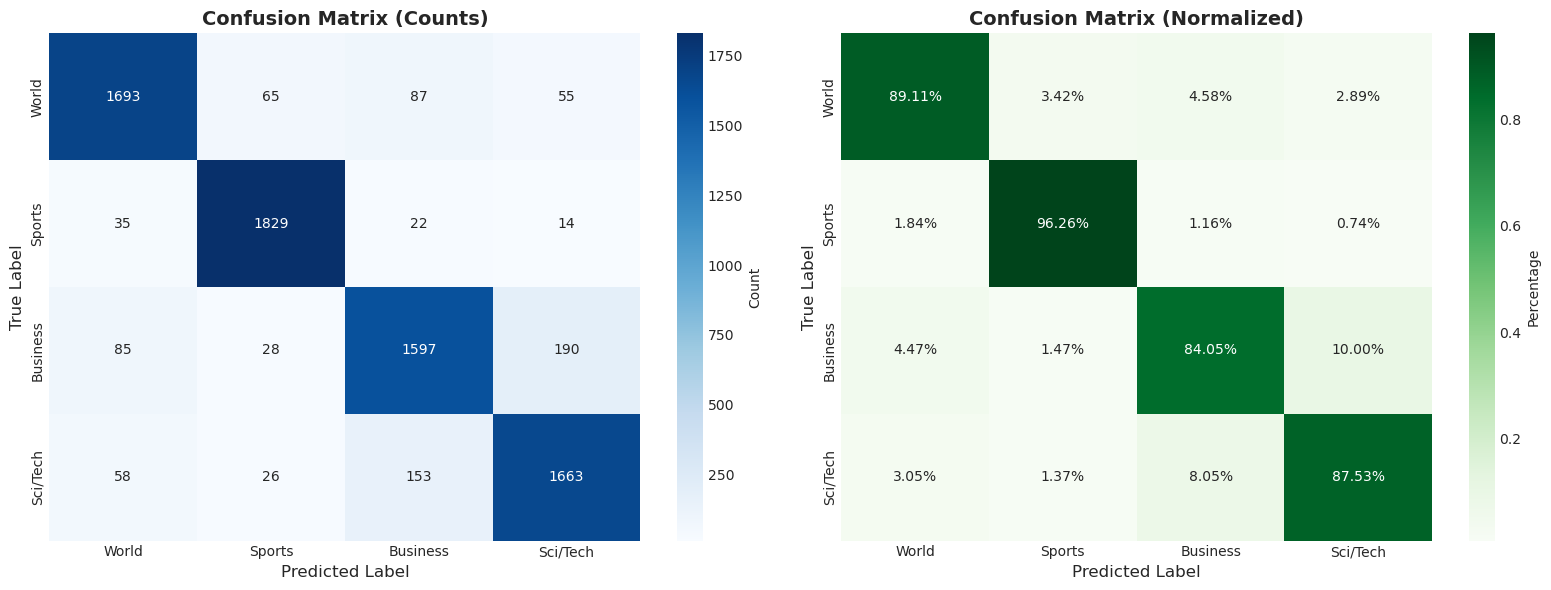

✓ Confusion matrix saved as 'confusion_matrix.png'

DETAILED CLASSIFICATION REPORT

              precision    recall  f1-score   support

       World     0.9049    0.8911    0.8979      1900
      Sports     0.9389    0.9626    0.9506      1900
    Business     0.8591    0.8405    0.8497      1900
    Sci/Tech     0.8652    0.8753    0.8702      1900

    accuracy                         0.8924      7600
   macro avg     0.8920    0.8924    0.8921      7600
weighted avg     0.8920    0.8924    0.8921      7600


ERROR ANALYSIS

1. Error Statistics:
   Total samples: 7600
   Correct predictions: 6782 (89.24%)
   Misclassified: 818 (10.76%)

2. Per-Class Error Rates:
   World          : 10.89% (207/1900 errors)
   Sports         : 3.74% (71/1900 errors)
   Business       : 15.95% (303/1900 errors)
   Sci/Tech       : 12.47% (237/1900 errors)

3. Prediction Confidence Analysis:
   Average confidence (correct): 0.9011
   Average confidence (incorrect): 0.6835
   Confidence difference: 0.

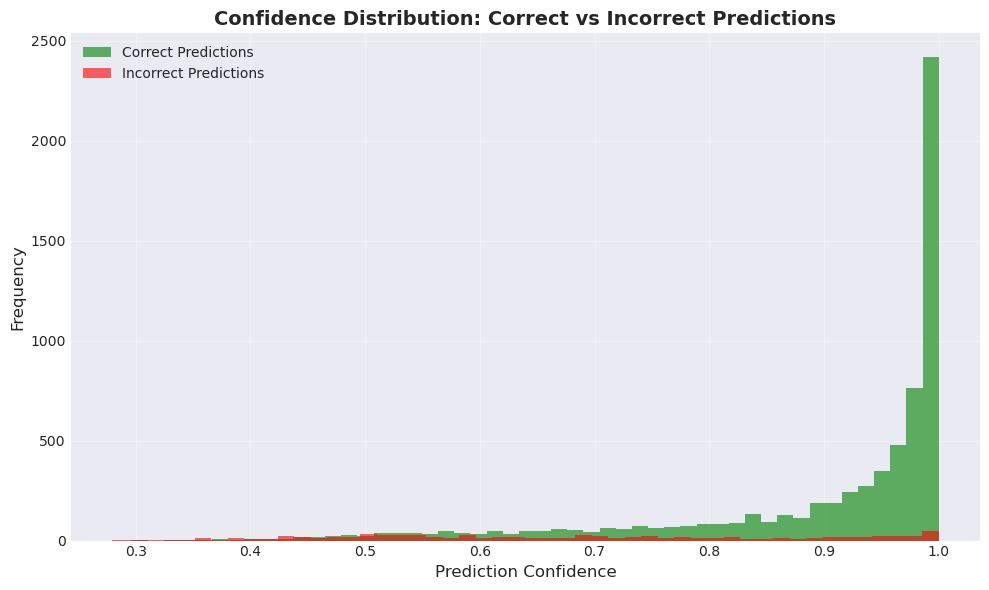

✓ Confidence distribution saved as 'confidence_distribution.png'

MODEL SAVING FOR DEPLOYMENT
✓ Model weights saved: 'text_classifier_weights.pth'
✓ Full model saved: 'text_classifier_full.pth'
✓ Model checkpoint with metadata saved: 'text_classifier_checkpoint.pth'
✓ Model information saved: 'model_info.json'

📦 All model files ready for deployment!

LOADING MODEL FOR DEPLOYMENT
✓ Model loaded successfully!
✓ Model accuracy: 0.8924
✓ Class labels: {0: 'World', 1: 'Sports', 2: 'Business', 3: 'Sci/Tech'}

PRODUCTION-READY PREDICTION SYSTEM
✓ News classifier initialized and ready!

TESTING PREDICTIONS

📝 Prediction Results:

1. Text: The football team won the championship game yesterday with a stunning ...
   ├─ Prediction: Sports
   ├─ Confidence: 1.0000 (100.00%)
   └─ All Probabilities:
      Sports         : 1.0000 ██████████████████████████████
      Sci/Tech       : 0.0000 
      World          : 0.0000 
      Business       : 0.0000 

2. Text: Stock markets reached all-time highs 

In [3]:
"""
=============================================================================
ADVANCED MODEL EVALUATION, ANALYSIS & DEPLOYMENT
=============================================================================
This notebook continues from the training phase and covers:
- Detailed model evaluation with metrics
- Confusion matrix and classification report
- Model architecture analysis
- Saving and loading models
- Deployment-ready prediction functions
- Error analysis
=============================================================================
"""

# =============================================================================
# STEP 12: IMPORT ADDITIONAL LIBRARIES FOR ANALYSIS
# =============================================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    classification_report, 
    confusion_matrix, 
    accuracy_score,
    precision_recall_fscore_support
)
import torch
import torch.nn as nn

# Set plot style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("✓ Libraries imported successfully")

# =============================================================================
# STEP 13: LOAD THE BEST MODEL
# =============================================================================
"""
After training (with 2 epochs as you mentioned), we load the best saved model.
"""

# Recreate model architecture (must match training)
class TextClassificationModel(nn.Module):
    def __init__(self, vocab_size, embed_dim, num_classes):
        super(TextClassificationModel, self).__init__()
        self.embedding = nn.EmbeddingBag(vocab_size, embed_dim, sparse=False)
        self.fc = nn.Linear(embed_dim, num_classes)

    def forward(self, text, offsets):
        embedded = self.embedding(text, offsets)
        return self.fc(embedded)

# Model parameters (from your training)
VOCAB_SIZE = 95811
EMBED_DIM = 64
NUM_CLASSES = 4
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize and load model
model = TextClassificationModel(VOCAB_SIZE, EMBED_DIM, NUM_CLASSES).to(device)
model.load_state_dict(torch.load('best_model.pth', map_location=device))
model.eval()

print("✓ Model loaded successfully")
print(f"✓ Model is on: {device}")

# =============================================================================
# STEP 14: MODEL ARCHITECTURE ANALYSIS
# =============================================================================
"""
Let's analyze the model architecture in detail.
"""

print("\n" + "="*70)
print("MODEL ARCHITECTURE ANALYSIS")
print("="*70)

# Print detailed architecture
print("\n1. Model Structure:")
print(model)

# Count parameters by layer
print("\n2. Parameters by Layer:")
total_params = 0
for name, param in model.named_parameters():
    num_params = param.numel()
    total_params += num_params
    print(f"   {name:20s}: {num_params:>12,} parameters | Shape: {list(param.shape)}")

print(f"\n   {'Total Parameters':20s}: {total_params:>12,}")

# Model size in MB
model_size_mb = total_params * 4 / (1024 ** 2)  # 4 bytes per float32
print(f"   {'Model Size':20s}: {model_size_mb:>12.2f} MB")

# Embedding layer analysis
print("\n3. Embedding Layer Details:")
print(f"   Vocabulary Size: {VOCAB_SIZE:,}")
print(f"   Embedding Dimension: {EMBED_DIM}")
print(f"   Embedding Parameters: {VOCAB_SIZE * EMBED_DIM:,}")
print(f"   Aggregation Mode: mean (averages word embeddings)")

# Classification layer analysis
print("\n4. Classification Layer Details:")
print(f"   Input Features: {EMBED_DIM}")
print(f"   Output Classes: {NUM_CLASSES}")
print(f"   Linear Parameters: {EMBED_DIM * NUM_CLASSES + NUM_CLASSES:,}")

print("\n" + "="*70)

# =============================================================================
# STEP 15: COMPREHENSIVE MODEL EVALUATION
# =============================================================================
"""
Evaluate model with detailed metrics on test set.
"""

def evaluate_with_predictions(model, dataloader, device):
    """
    Evaluate model and return predictions for detailed analysis.
    """
    model.eval()
    all_predictions = []
    all_labels = []
    all_probabilities = []
    
    with torch.no_grad():
        for labels, text, offsets in dataloader:
            outputs = model(text, offsets)
            probabilities = torch.softmax(outputs, dim=1)
            predictions = outputs.argmax(dim=1)
            
            all_predictions.extend(predictions.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probabilities.extend(probabilities.cpu().numpy())
    
    return np.array(all_predictions), np.array(all_labels), np.array(all_probabilities)

print("\n" + "="*70)
print("EVALUATING MODEL ON TEST SET")
print("="*70)

# Get predictions (assuming test_loader is available)
# If not, you'll need to recreate it from the previous code
y_pred, y_true, y_proba = evaluate_with_predictions(model, test_loader, device)

print(f"✓ Evaluated {len(y_true)} test samples")

# =============================================================================
# STEP 16: CALCULATE DETAILED METRICS
# =============================================================================

class_labels = {0: 'World', 1: 'Sports', 2: 'Business', 3: 'Sci/Tech'}
class_names = list(class_labels.values())

print("\n" + "="*70)
print("PERFORMANCE METRICS")
print("="*70)

# Overall accuracy
accuracy = accuracy_score(y_true, y_pred)
print(f"\n1. Overall Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")

# Per-class metrics
precision, recall, f1, support = precision_recall_fscore_support(
    y_true, y_pred, average=None, labels=[0, 1, 2, 3]
)

print("\n2. Per-Class Metrics:")
print("-" * 70)
print(f"{'Class':<15} {'Precision':<12} {'Recall':<12} {'F1-Score':<12} {'Support':<10}")
print("-" * 70)
for i, class_name in enumerate(class_names):
    print(f"{class_name:<15} {precision[i]:<12.4f} {recall[i]:<12.4f} "
          f"{f1[i]:<12.4f} {support[i]:<10}")
print("-" * 70)

# Macro and weighted averages
macro_precision, macro_recall, macro_f1, _ = precision_recall_fscore_support(
    y_true, y_pred, average='macro'
)
weighted_precision, weighted_recall, weighted_f1, _ = precision_recall_fscore_support(
    y_true, y_pred, average='weighted'
)

print(f"\n3. Averaged Metrics:")
print(f"   Macro Average    - Precision: {macro_precision:.4f}, Recall: {macro_recall:.4f}, F1: {macro_f1:.4f}")
print(f"   Weighted Average - Precision: {weighted_precision:.4f}, Recall: {weighted_recall:.4f}, F1: {weighted_f1:.4f}")

# =============================================================================
# STEP 17: CONFUSION MATRIX VISUALIZATION
# =============================================================================

print("\n" + "="*70)
print("CONFUSION MATRIX")
print("="*70)

# Calculate confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Create figure
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Raw counts
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names,
            ax=axes[0], cbar_kws={'label': 'Count'})
axes[0].set_title('Confusion Matrix (Counts)', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Predicted Label', fontsize=12)
axes[0].set_ylabel('True Label', fontsize=12)

# Plot 2: Normalized (percentages)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm_normalized, annot=True, fmt='.2%', cmap='Greens',
            xticklabels=class_names, yticklabels=class_names,
            ax=axes[1], cbar_kws={'label': 'Percentage'})
axes[1].set_title('Confusion Matrix (Normalized)', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Predicted Label', fontsize=12)
axes[1].set_ylabel('True Label', fontsize=12)

plt.tight_layout()
plt.savefig('confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Confusion matrix saved as 'confusion_matrix.png'")

# =============================================================================
# STEP 18: CLASSIFICATION REPORT
# =============================================================================

print("\n" + "="*70)
print("DETAILED CLASSIFICATION REPORT")
print("="*70)
print()
print(classification_report(y_true, y_pred, target_names=class_names, digits=4))

# =============================================================================
# STEP 19: ERROR ANALYSIS
# =============================================================================

print("\n" + "="*70)
print("ERROR ANALYSIS")
print("="*70)

# Find misclassified samples
misclassified_indices = np.where(y_pred != y_true)[0]
correct_indices = np.where(y_pred == y_true)[0]

print(f"\n1. Error Statistics:")
print(f"   Total samples: {len(y_true)}")
print(f"   Correct predictions: {len(correct_indices)} ({len(correct_indices)/len(y_true)*100:.2f}%)")
print(f"   Misclassified: {len(misclassified_indices)} ({len(misclassified_indices)/len(y_true)*100:.2f}%)")

# Per-class error rates
print(f"\n2. Per-Class Error Rates:")
for i, class_name in enumerate(class_names):
    class_indices = np.where(y_true == i)[0]
    class_errors = np.sum(y_pred[class_indices] != y_true[class_indices])
    error_rate = class_errors / len(class_indices) * 100
    print(f"   {class_name:<15}: {error_rate:.2f}% ({class_errors}/{len(class_indices)} errors)")

# Confidence analysis
print(f"\n3. Prediction Confidence Analysis:")
max_probs = y_proba.max(axis=1)
correct_confidences = max_probs[correct_indices]
incorrect_confidences = max_probs[misclassified_indices]

print(f"   Average confidence (correct): {correct_confidences.mean():.4f}")
print(f"   Average confidence (incorrect): {incorrect_confidences.mean():.4f}")
print(f"   Confidence difference: {correct_confidences.mean() - incorrect_confidences.mean():.4f}")

# Visualize confidence distribution
fig, ax = plt.subplots(figsize=(10, 6))
ax.hist(correct_confidences, bins=50, alpha=0.6, label='Correct Predictions', color='green')
ax.hist(incorrect_confidences, bins=50, alpha=0.6, label='Incorrect Predictions', color='red')
ax.set_xlabel('Prediction Confidence', fontsize=12)
ax.set_ylabel('Frequency', fontsize=12)
ax.set_title('Confidence Distribution: Correct vs Incorrect Predictions', 
             fontsize=14, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('confidence_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Confidence distribution saved as 'confidence_distribution.png'")

# =============================================================================
# STEP 20: MODEL SAVING (DEPLOYMENT-READY)
# =============================================================================

print("\n" + "="*70)
print("MODEL SAVING FOR DEPLOYMENT")
print("="*70)

# Method 1: Save only model weights (lighter)
torch.save(model.state_dict(), 'text_classifier_weights.pth')
print("✓ Model weights saved: 'text_classifier_weights.pth'")

# Method 2: Save entire model (includes architecture)
torch.save(model, 'text_classifier_full.pth')
print("✓ Full model saved: 'text_classifier_full.pth'")

# Method 3: Save with metadata (best practice)
checkpoint = {
    'model_state_dict': model.state_dict(),
    'vocab_size': VOCAB_SIZE,
    'embed_dim': EMBED_DIM,
    'num_classes': NUM_CLASSES,
    'class_labels': class_labels,
    'accuracy': accuracy,
    'model_architecture': str(model)
}
torch.save(checkpoint, 'text_classifier_checkpoint.pth')
print("✓ Model checkpoint with metadata saved: 'text_classifier_checkpoint.pth'")

# Save model info as JSON
import json

model_info = {
    'model_name': 'TextClassificationModel',
    'task': 'News Classification',
    'dataset': 'AG_NEWS',
    'vocab_size': VOCAB_SIZE,
    'embed_dim': EMBED_DIM,
    'num_classes': NUM_CLASSES,
    'class_labels': class_labels,
    'accuracy': float(accuracy),
    'macro_f1': float(macro_f1),
    'training_epochs': 2,
    'total_parameters': total_params,
    'model_size_mb': float(model_size_mb)
}

with open('model_info.json', 'w') as f:
    json.dump(model_info, f, indent=4)

print("✓ Model information saved: 'model_info.json'")

print("\n📦 All model files ready for deployment!")

# =============================================================================
# STEP 21: LOAD MODEL (DEPLOYMENT SCENARIO)
# =============================================================================

print("\n" + "="*70)
print("LOADING MODEL FOR DEPLOYMENT")
print("="*70)

def load_model_for_inference(checkpoint_path, device='cpu'):
    """
    Load model from checkpoint for inference.
    
    Args:
        checkpoint_path: Path to checkpoint file
        device: Device to load model on
    
    Returns:
        model: Loaded model in eval mode
        metadata: Model metadata
    """
    # Load checkpoint
    checkpoint = torch.load(checkpoint_path, map_location=device)
    
    # Extract metadata
    vocab_size = checkpoint['vocab_size']
    embed_dim = checkpoint['embed_dim']
    num_classes = checkpoint['num_classes']
    class_labels = checkpoint['class_labels']
    
    # Recreate model
    model = TextClassificationModel(vocab_size, embed_dim, num_classes)
    model.load_state_dict(checkpoint['model_state_dict'])
    model.to(device)
    model.eval()
    
    metadata = {
        'class_labels': class_labels,
        'accuracy': checkpoint.get('accuracy', 'N/A')
    }
    
    return model, metadata

# Load the model
loaded_model, metadata = load_model_for_inference('text_classifier_checkpoint.pth', device)
print("✓ Model loaded successfully!")
print(f"✓ Model accuracy: {metadata['accuracy']:.4f}")
print(f"✓ Class labels: {metadata['class_labels']}")

# =============================================================================
# STEP 22: PRODUCTION-READY PREDICTION FUNCTION
# =============================================================================

print("\n" + "="*70)
print("PRODUCTION-READY PREDICTION SYSTEM")
print("="*70)

class NewsClassifier:
    """
    Production-ready news classifier with preprocessing and post-processing.
    """
    
    def __init__(self, model, vocab, tokenizer, class_labels, device='cpu'):
        self.model = model
        self.vocab = vocab
        self.tokenizer = tokenizer
        self.class_labels = class_labels
        self.device = device
        self.model.eval()
    
    def preprocess(self, text):
        """Preprocess input text."""
        # Convert to lowercase and tokenize
        tokens = self.tokenizer(text.lower())
        # Convert to vocab indices
        indices = self.vocab(tokens)
        return torch.tensor(indices, dtype=torch.int64)
    
    def predict(self, text, return_probabilities=False):
        """
        Predict class for input text.
        
        Args:
            text: Input text string
            return_probabilities: If True, return class probabilities
        
        Returns:
            prediction: Predicted class label
            confidence: Confidence score
            (probabilities: Class probabilities if return_probabilities=True)
        """
        # Preprocess
        text_tensor = self.preprocess(text).to(self.device)
        offsets = torch.tensor([0], dtype=torch.int64).to(self.device)
        
        # Predict
        with torch.no_grad():
            output = self.model(text_tensor, offsets)
            probabilities = torch.softmax(output, dim=1)
            predicted_class = output.argmax(1).item()
            confidence = probabilities[0][predicted_class].item()
        
        prediction = self.class_labels[predicted_class]
        
        if return_probabilities:
            probs_dict = {self.class_labels[i]: probabilities[0][i].item() 
                         for i in range(len(self.class_labels))}
            return prediction, confidence, probs_dict
        
        return prediction, confidence
    
    def predict_batch(self, texts):
        """Predict for multiple texts."""
        predictions = []
        for text in texts:
            pred, conf = self.predict(text)
            predictions.append({'text': text, 'prediction': pred, 'confidence': conf})
        return predictions

# Initialize classifier (you'll need vocab and tokenizer from training)
# Assuming these are available from your training code
classifier = NewsClassifier(
    model=loaded_model,
    vocab=vocab,  # From training
    tokenizer=tokenizer,  # From training
    class_labels=class_labels,
    device=device
)

print("✓ News classifier initialized and ready!")

# =============================================================================
# STEP 23: TEST PREDICTIONS WITH DETAILED OUTPUT
# =============================================================================

print("\n" + "="*70)
print("TESTING PREDICTIONS")
print("="*70)

# Test samples
test_samples = [
    "The football team won the championship game yesterday with a stunning performance.",
    "Stock markets reached all-time highs today as investors show confidence.",
    "Scientists discovered a new exoplanet that could potentially harbor life.",
    "World leaders met in Geneva to discuss climate change policies.",
    "Apple announced record-breaking quarterly earnings beating analyst expectations.",
    "The tennis star won her fifth Grand Slam title in an exciting final match.",
]

print("\n📝 Prediction Results:\n")
for i, text in enumerate(test_samples, 1):
    prediction, confidence, probabilities = classifier.predict(
        text, return_probabilities=True
    )
    
    print(f"{i}. Text: {text[:70]}...")
    print(f"   ├─ Prediction: {prediction}")
    print(f"   ├─ Confidence: {confidence:.4f} ({confidence*100:.2f}%)")
    print(f"   └─ All Probabilities:")
    for label, prob in sorted(probabilities.items(), key=lambda x: x[1], reverse=True):
        bar = "█" * int(prob * 30)
        print(f"      {label:<15}: {prob:.4f} {bar}")
    print()

# =============================================================================
# STEP 24: BATCH PREDICTION EXAMPLE
# =============================================================================

print("\n" + "="*70)
print("BATCH PREDICTION EXAMPLE")
print("="*70)

batch_texts = [
    "NASA launches new Mars rover mission",
    "Premier League results and standings",
    "Federal Reserve announces interest rate decision"
]

batch_results = classifier.predict_batch(batch_texts)

print("\n📊 Batch Results:\n")
results_df = pd.DataFrame(batch_results)
print(results_df.to_string(index=False))

# =============================================================================
# STEP 25: MODEL PERFORMANCE SUMMARY
# =============================================================================

print("\n" + "="*70)
print("FINAL MODEL PERFORMANCE SUMMARY")
print("="*70)

summary = f"""
📊 MODEL PERFORMANCE REPORT
{'='*70}

🎯 Overall Metrics:
   • Accuracy:           {accuracy:.4f} ({accuracy*100:.2f}%)
   • Macro F1-Score:     {macro_f1:.4f}
   • Weighted F1-Score:  {weighted_f1:.4f}

📈 Best Performing Class: {class_names[np.argmax(f1)]} (F1: {np.max(f1):.4f})
📉 Needs Improvement:     {class_names[np.argmin(f1)]} (F1: {np.min(f1):.4f})

💾 Model Details:
   • Total Parameters:   {total_params:,}
   • Model Size:         {model_size_mb:.2f} MB
   • Training Epochs:    2
   • Device:             {device}

📁 Saved Files:
   ✓ best_model.pth (weights only)
   ✓ text_classifier_checkpoint.pth (with metadata)
   ✓ model_info.json (model information)
   ✓ confusion_matrix.png (visualization)
   ✓ confidence_distribution.png (analysis)

🚀 Model is ready for deployment!
{'='*70}
"""

print(summary)

# Save summary to file
with open('model_performance_summary.txt', 'w') as f:
    f.write(summary)

print("✓ Performance summary saved to 'model_performance_summary.txt'")

print("\n" + "="*70)
print("✅ EVALUATION AND DEPLOYMENT PIPELINE COMPLETED!")
print("="*70)

In [63]:
!pip install numpy==1.26.4



  Using cached numpy-1.26.4-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (61 kB)
Using cached numpy-1.26.4-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (18.0 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 2.2.6
    Uninstalling numpy-2.2.6:
      Successfully uninstalled numpy-2.2.6
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pyiron-base 0.10.9 requires sqlalchemy<=2.0.36,>=2.0.22, but you have sqlalchemy 2.0.40 which is incompatible.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompatible.
pyiron-atomistics 0.6.18 requires scikit-learn<=1.6.0,>=1.2.1, but you have scikit-learn 1.7.1 which is incompatible.


In [22]:
#import bank datasets, an iterable dataset (best for text data)
train_iter = iter(AG_NEWS(split='train'))
y, text = next((train_iter))
print(y,text)

3 Wall St. Bears Claw Back Into the Black (Reuters) Reuters - Short-sellers, Wall Street's dwindling\band of ultra-cynics, are seeing green again.


In [4]:
ag_news_label = {1:'World', 2: 'Sports', 3: 'Buisness', 4: 'Sci/Tech'}
ag_news_label[y]
# Use datasets to find all the classes, restart the iterator once you done. 
num_class = set([label for (label, text) in train_iter])
num_class

{1, 2, 3, 4}

In [5]:
# REinitialize train iterator
train_iter = AG_NEWS(split="train")

# Define Tokenizer and yield tokens 
tokenizer = get_tokenizer("basic_english")

# Yield the text iteratively and tokenize
def yield_token (data_iter):
    for label, text in data_iter:
        yield tokenizer(text.lower())
        
# Build Vocabulary
vocab = build_vocab_from_iterator(yield_token(train_iter), specials=['<unk>']) # special means 'unknow' words
vocab.set_default_index(vocab['<unk>']) # return <unk> index which is [0]

#print vocab size and sample tokens 
print(f"Vocabulary sizee: {len(vocab)}")
print(f'Sample Tokens: {list(vocab.get_stoi().keys())[:10]}')

Vocabulary sizee: 95811
Sample Tokens: ['zzz', 'zygmunt', 'zwiki', 'zvidauri', 'zurine', 'zurab', 'zuo', 'zuloaga', 'zovko', 'zotinca']


In [6]:
vocab(['ram'])

[9697]

## Dataset
- Convert the dataset into map-style format for easier acess and manipulation 
- Perform a random split to seperate data into:
  - Training dataset = 95% 
  - Validation dataset = 5%
  

In [7]:
#split the data set into traning and testing iterator 
train_iter, test_iter = AG_NEWS()

# Convert the training and testing iterators to map-style datasets.
train_dataset = to_map_style_dataset(train_iter)
test_dataset = to_map_style_dataset(test_iter)

# Determine the number of samples to be used for training and validation (5% for validation)
num_train = int(len(train_dataset)*0.95)

# Randomly split the training  dataset into training and validation datasets using 'random_split'
split_train_, split_valid_ = random_split(train_dataset, [num_train, len(train_dataset)-num_train])


### Let us check if we have GPU or CPU device

In [19]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

- Set up text processing pipeline using tokenizer and vocabulary for handling raw data. 

- Use text and label pipelines to process dataset iterator ouputs:
      - text_pipeline : Tokenizes input text, then applies the vocab to convert token into numerical indices. 
      - label_pipeline : Adjust labels so they start at zero for consistent model training 
  

In [20]:
def text_pipeline(x):
    return vocab(tokenizer(x))

def label_pipeline(x):
    return int(x)-1

- In Pytorch, `collate_fn` customizes how batches are created from indivisual samples in data loaders.
- The collate_batch funtion processes eacah batch by :
     - Applying `label_pipeline` to preprocess labels. 
     - Applying `text_pipeline` to process text sequences
- Converts the processed data into Pytorch tensors:
     - label tensor - contains the numberical labels 
     - text tensors - contains tokenized and indexed text data 
     - offset tensor - Indicates starting positions of each text sequence in combined tensor. 

- Moves all tensors to the specified device(gpu, cpu) for faster computations


In [21]:
def collate_batch(batch):
  
    label_list, text_list, offsets = [], [], [0]  # The thrid list is not empy 
    for _label, _text in batch:
        label_list.append(label_pipeline(_label))
        processed_text = torch.tensor(text_pipeline(_text), dtype=torch.int64)
        text_list.append(processed_text)
        offsets.append(processed_text.size(0)) # size(0) not [0]
        
    #Turn lists into tensors
    label_list = torch.tensor(label_list, dtype=torch.int64)
    offsets = torch.tensor(offsets[:-1]).cumsum(dim=0)  # cumsum fn is outside the tensor, 
    text_list = torch.cat(text_list)
    
    return label_list.to(device), text_list.to(device), offsets.to(device)

In [11]:
BATCH_SIZE = 64
train_dataloader =  DataLoader(split_train_, batch_size=BATCH_SIZE, shuffle=True,  collate_fn=collate_batch)
valid_dataloader = DataLoader(split_valid_,batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_batch)
test_dataloader = DataLoader(test_dataset, shuffle=True, batch_size=BATCH_SIZE, collate_fn=collate_batch)

- A quick check to see inside the dataloader

In [28]:
label, text, offsets = next(iter(valid_dataloader))
label, text, offsets
len(label)

64

In [13]:
import torch

# pretend pipelines
label_pipeline = lambda x: int(x)
text_pipeline = lambda x: [ord(c) - 96 for c in x]  # simple fake encoding (a=1, b=2, ...)

def collate_batch(batch):
    label_list, text_list, offsets = [], [], [0]
    for _label, _text in batch:
        label_list.append(label_pipeline(_label))
        processed_text = torch.tensor(text_pipeline(_text), dtype=torch.int64)
        text_list.append(processed_text)
        offsets.append(processed_text.size(0))
    
    #Turn lists into tensors
    label_list = torch.tensor(label_list, dtype=torch.int64)
    offsets = torch.tensor(offsets[:-1]).cumsum(dim=0)
    text_list = torch.cat(text_list)
    
    return label_list, text_list, offsets

# Dummy batch: list of (label, text)
batch = [
    (1, "abc"),   # len=3
    (0, "de"),    # len=2
    (1, "fghi"),  # len=4
]

labels, text, offsets = collate_batch(batch)

print("labels:", labels)
print("text:", text)
print("offsets:", offsets)


labels: tensor([1, 0, 1])
text: tensor([1, 2, 3, 4, 5, 6, 7, 8, 9])
offsets: tensor([0, 3, 5])




We'll break it into **four parts**, each with diagrams and examples.

---

## 🧩 What problem `collate_batch()` solves

When using a PyTorch `DataLoader`, each batch looks like this before processing:

```python
batch = [
    (label1, text1),
    (label2, text2),
    (label3, text3),
    ...
]
```

But **texts are variable-length sequences** (e.g., “I love NLP” has 3 tokens, “PyTorch rocks” has 2).

Neural networks need **tensors of numbers**, not strings — and ideally **all sequences combined** efficiently (without padding).

---

## 🧱 Step 1: Starting the function

```python
def collate_batch(batch):
    label_list, text_list, offsets = [], [], [0]
```

* `label_list`: we’ll store all numeric labels.
* `text_list`: we’ll store tensors of token IDs (for each sentence).
* `offsets`: we’ll store **where each text starts** in a big flattened text tensor.

---

### ⚙️ Why `offsets` starts with `[0]`

Think of `offsets` as “the start index of each text inside one long list”.

If you later merge all sentences into one big tensor like this:

```
[text1 tokens][text2 tokens][text3 tokens]
```

Then:

* text1 starts at **index 0** (so we begin with `[0]`)
* text2 will start at the length of text1
* text3 will start at length(text1) + length(text2)
* and so on

That’s why we start with `[0]` instead of `[]`.

---

## 🧱 Step 2: Looping through the batch

```python
for _label, _text in batch:
    label_list.append(label_pipeline(_label))
    processed_text = torch.tensor(text_pipeline(_text), dtype=torch.int64)
    text_list.append(processed_text)
    offsets.append(processed_text.size(0))
```

Let’s unpack this line by line.

### 🟣 `label_pipeline(_label)`

Converts a label (like `'1'` or `'pos'`) into a numeric ID, e.g.:

```python
label_pipeline = lambda x: int(x)
```

### 🟣 `text_pipeline(_text)`

Converts a text into numeric tokens, e.g.:

```python
text_pipeline = lambda x: [ord(c) - 96 for c in x]   # 'a'→1, 'b'→2, ...
```

---

### 🧮 Example batch

Let’s take this batch:

```python
batch = [
    (1, "abc"),   # 3 tokens
    (0, "de"),    # 2 tokens
    (1, "fghi"),  # 4 tokens
]
```

After tokenizing:

| Label | Text   | Token IDs    | Length |
| ----- | ------ | ------------ | ------ |
| 1     | "abc"  | [1, 2, 3]    | 3      |
| 0     | "de"   | [4, 5]       | 2      |
| 1     | "fghi" | [6, 7, 8, 9] | 4      |

Now let’s see how the code behaves step by step:

### After first sample (`"abc"`)

* `label_list = [1]`
* `text_list = [[1,2,3]]`
* `offsets = [0, 3]` (since length of `"abc"` = 3)

### After second sample (`"de"`)

* `label_list = [1, 0]`
* `text_list = [[1,2,3], [4,5]]`
* `offsets = [0, 3, 2]` (add size(0)=2)

### After third sample (`"fghi"`)

* `label_list = [1, 0, 1]`
* `text_list = [[1,2,3], [4,5], [6,7,8,9]]`
* `offsets = [0, 3, 2, 4]`

Notice that `offsets` currently holds **lengths**, not start positions.

---

## 🧱 Step 3: Turn lists into tensors

```python
label_list = torch.tensor(label_list, dtype=torch.int64)
offsets = torch.tensor(offsets[:-1]).cumsum(dim=0)
text_list = torch.cat(text_list)
```

Let’s go line by line.

### 1️⃣ `label_list`

→ becomes a tensor:
`tensor([1, 0, 1])`

### 2️⃣ `offsets`

* First, `offsets[:-1]` removes the last value (the final total length)
  So `[0, 3, 2, 4]` → `[0, 3, 2]`

* Then `.cumsum(dim=0)` calculates **cumulative sums**:

  ```
  cumulative sum of [0, 3, 2] = [0, 3, 5]
  ```

Now `offsets` means:

* text1 starts at 0
* text2 starts at 3
* text3 starts at 5

✅ Perfect — those are the starting indices in the big flattened text tensor.

### 3️⃣ `text_list = torch.cat(text_list)`

This joins all token tensors into one long sequence:

```
[1, 2, 3, 4, 5, 6, 7, 8, 9]
```

---

## 🧱 Step 4: Return tensors

```python
return label_list, text_list, offsets
```

So our final result is:

| Variable     | Tensor                | Meaning                 |
| ------------ | --------------------- | ----------------------- |
| `label_list` | `[1, 0, 1]`           | labels for each text    |
| `text_list`  | `[1,2,3,4,5,6,7,8,9]` | all tokens concatenated |
| `offsets`    | `[0, 3, 5]`           | where each text starts  |

---

## 🎯 Why this structure matters

This exact structure (`text`, `offsets`) is **required** by:

```python
torch.nn.EmbeddingBag
```

which can handle **variable-length sequences without padding**.

When you pass:

```python
embedding_bag(text_list, offsets)
```

it automatically groups embeddings for each text using these offsets:

* text1 uses embeddings from indices 0→2
* text2 uses 3→4
* text3 uses 5→8

---

## 🧠 TL;DR Summary Table

| Code                                     | Meaning                               | Example               |
| ---------------------------------------- | ------------------------------------- | --------------------- |
| `offsets = [0]`                          | mark where first text starts          | `[0]`                 |
| `offsets.append(processed_text.size(0))` | record length of each text            | `[0,3,2,4]`           |
| `offsets[:-1]`                           | remove last (not needed)              | `[0,3,2]`             |
| `.cumsum(dim=0)`                         | convert lengths to starting positions | `[0,3,5]`             |
| `torch.cat(text_list)`                   | flatten all token tensors             | `[1,2,3,4,5,6,7,8,9]` |

---

Would you like me to **visualize this** (with a diagram showing how `offsets` map into the big concatenated tensor)?
That often makes it click instantly.


# Desing a Neural Network using Pytorch

In [14]:

class TextClassificationModel(nn.Module):
      def __init__(self, vocab_size, embed_dim, num_class):
          super(TextClassificationModel, self).__init__()
          self.embedding = nn.EmbeddingBag(vocab_size, embed_dim, sparse=False,include_last_offset=True)
          self.fc = nn.Linear(embed_dim,num_class)
          self.init_weights()
      
      def init_weights(self):
           initrange = 0.5
           self.embedding.weight.data.uniform_(-initrange, initrange)
           self.fc.weight.data.uniform_(-initrange, initrange)
           self.fc.bias.data.zero_()
      def forward(self, text, offsets):
          embedded = self.embedding(text, offsets)
          return self.fc(embedded)

LR =0.1 # Learning rate

embed_dim = 64 
vocab_size = len(vocab)
num_class = 4
model = TextClassificationModel(vocab_size,embed_dim, num_class).to(device)

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr = LR)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.1)    

In [15]:
vocab_size

95811

In [16]:
model

TextClassificationModel(
  (embedding): EmbeddingBag(95811, 64, mode='mean')
  (fc): Linear(in_features=64, out_features=4, bias=True)
)

The code line `predicted_label = model(text, offsets)` is used to obtain predicted labels from a machine learning for a given input text and its corresponding offsets. The model is the machine learning model being used to text classification or similar task.

In [29]:
predicted_label = model(text, offsets)

Now, verify the output shape of your model, the model is trained with a mini-batch  of 64 samples. The output layer of the model produces four logits for each neuron, correspoinding ot the four classses in the classification task. YOu can also create a funtion to find the accuracy given a dataset. 

In [31]:
predicted_label.shape

torch.Size([63, 4])

In [32]:
def evaluate(dataloader):
    model.eval()
    total_acc, total_count= 0, 0

    with torch.no_grad():
        for idx, (label, text, offsets) in enumerate(dataloader):
            predicted_label = model(text, offsets)

            total_acc += (predicted_label.argmax(1) == label).sum().item()
            total_count += label.size(0)
    return total_acc / total_count

In [33]:

EPOCHS = 10
cum_loss_list = []
acc_epoch = []
acc_old = 0

for epoch in tqdm(range(1, EPOCHS+1)):
    model.train()
    cum_loss = 0
    
    for idx, (label, text, offsets) in enumerate(train_dataloader):
        optimizer.zero_grad()
        predicted_label = model(text,offsets)
        loss = criterion(predicted_label,label)
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(),0.1)
        optimizer.step()
        cum_loss += loss.item()
    cum_loss_list.append(cum_loss)
    accu_val = evaluate(valid_dataloader)
    acc_epoch.append(accu_val)
    

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]


ValueError: Expected input batch_size (63) to match target batch_size (64).

In [34]:
# Reinitialize train_iter
train_iter = AG_NEWS(split="train")

# Define tokenizer and yield_tokens
tokenizer = get_tokenizer("basic_english")

def yield_tokens(data_iter):
    for _, text in data_iter:
        yield tokenizer(text.lower())  # Lowercase conversion for consistency

# Build vocabulary
vocab = build_vocab_from_iterator(yield_tokens(train_iter), specials=["<unk>"])
vocab.set_default_index(vocab["<unk>"])

# Print the vocabulary size and sample tokens
print(f"Vocabulary size: {len(vocab)}")
print(f"Sample tokens: {list(vocab.get_stoi().keys())[:10]}")


Vocabulary size: 95811
Sample tokens: ['zzz', 'zygmunt', 'zwiki', 'zvidauri', 'zurine', 'zurab', 'zuo', 'zuloaga', 'zovko', 'zotinca']


In [35]:
vocab(["age","hello"])

[2120, 12544]

In [36]:
# Split the dataset into training and testing iterators.
train_iter, test_iter = AG_NEWS()

# Convert the training and testing iterators to map-style datasets.
train_dataset = to_map_style_dataset(train_iter)
test_dataset = to_map_style_dataset(test_iter)

# Determine the number of samples to be used for training and validation (5% for validation).
num_train = int(len(train_dataset) * 0.95)

# Randomly split the training dataset into training and validation datasets using `random_split`.
# The training dataset will contain 95% of the samples, and the validation dataset will contain the remaining 5%.
split_train_, split_valid_ = random_split(train_dataset, [num_train, len(train_dataset) - num_train])

In [37]:
def text_pipeline(x):
  return vocab(tokenizer(x))

def label_pipeline(x):
   return int(x) - 1

In [38]:
def collate_batch(batch):
    label_list, text_list, offsets = [], [], [0]
    for _label, _text in batch:
        label_list.append(label_pipeline(_label))
        processed_text = torch.tensor(text_pipeline(_text), dtype=torch.int64)
        text_list.append(processed_text)
        offsets.append(processed_text.size(0))
    label_list = torch.tensor(label_list, dtype=torch.int64)
    offsets = torch.tensor(offsets[:-1]).cumsum(dim=0)
    text_list = torch.cat(text_list)
    return label_list.to(device), text_list.to(device), offsets.to(device)

In [39]:
BATCH_SIZE = 64

train_dataloader = DataLoader(
    split_train_, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_batch
)
valid_dataloader = DataLoader(
    split_valid_, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_batch
)
test_dataloader = DataLoader(
    test_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_batch
)

In [40]:
label, text, offsets=next(iter(valid_dataloader )) 
label, text, offsets

(tensor([2, 0, 2, 2, 3, 3, 1, 1, 3, 0, 1, 2, 3, 0, 3, 3, 3, 0, 3, 1, 3, 1, 1, 1,
         1, 3, 2, 2, 2, 1, 1, 2, 2, 3, 2, 0, 2, 0, 0, 3, 0, 3, 0, 3, 2, 1, 3, 3,
         1, 3, 3, 2, 2, 0, 2, 2, 0, 3, 0, 2, 2, 2, 3, 0]),
 tensor([15976,    28,   153,  ...,    35, 30112,     1]),
 tensor([   0,   55,   98,  145,  212,  243,  317,  370,  417,  456,  498,  541,
          573,  624,  664,  688,  776,  802,  837,  861,  904,  942,  981, 1007,
         1046, 1087, 1110, 1166, 1228, 1270, 1300, 1338, 1377, 1417, 1473, 1525,
         1572, 1637, 1662, 1691, 1740, 1791, 1819, 1878, 1944, 1984, 2029, 2056,
         2078, 2123, 2164, 2201, 2237, 2286, 2359, 2402, 2441, 2488, 2537, 2580,
         2611, 2649, 2696, 2729]))

In [41]:
from torch import nn

class TextClassificationModel(nn.Module):
    def __init__(self, vocab_size, embed_dim, num_class):
        super(TextClassificationModel, self).__init__()
        self.embedding = nn.EmbeddingBag(vocab_size, embed_dim, sparse=False)
        self.fc = nn.Linear(embed_dim, num_class)
        self.init_weights()

    def init_weights(self):
        initrange = 0.5
        self.embedding.weight.data.uniform_(-initrange, initrange)
        self.fc.weight.data.uniform_(-initrange, initrange)
        self.fc.bias.data.zero_()

    def forward(self, text, offsets):
        embedded = self.embedding(text, offsets)
        return self.fc(embedded)

In [42]:
emsize=64

In [43]:
vocab_size=len(vocab)
vocab_size

95811

In [44]:
num_class 

4

In [45]:
model = TextClassificationModel(vocab_size, emsize, num_class).to(device)
model

TextClassificationModel(
  (embedding): EmbeddingBag(95811, 64, mode='mean')
  (fc): Linear(in_features=64, out_features=4, bias=True)
)

In [46]:
predicted_label=model(text, offsets)

In [47]:
def predict(text, text_pipeline):
    with torch.no_grad():
        text = torch.tensor(text_pipeline(text))
        output = model(text, torch.tensor([0]))
        return ag_news_label[output.argmax(1).item() + 1]

In [48]:
predict("I like sports",text_pipeline )

'Sci/Tech'

In [49]:
def evaluate(dataloader):
    model.eval()
    total_acc, total_count= 0, 0

    with torch.no_grad():
        for idx, (label, text, offsets) in enumerate(dataloader):
            predicted_label = model(text, offsets)

            total_acc += (predicted_label.argmax(1) == label).sum().item()
            total_count += label.size(0)
    return total_acc / total_count

In [50]:
evaluate(test_dataloader)

0.2668421052631579

In [51]:
LR=0.1

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=LR)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.1)

In [52]:
EPOCHS = 10
cum_loss_list=[]
acc_epoch=[]
acc_old=0

for epoch in tqdm(range(1, EPOCHS + 1)):
    model.train()
    cum_loss=0
    for idx, (label, text, offsets) in enumerate(train_dataloader):
        optimizer.zero_grad()
        predicted_label = model(text, offsets)
        loss = criterion(predicted_label, label)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.1)
        optimizer.step()
        cum_loss+=loss.item()

    cum_loss_list.append(cum_loss)
    accu_val = evaluate(valid_dataloader)
    acc_epoch.append(accu_val)

    if accu_val > acc_old:
      acc_old= accu_val
      torch.save(model.state_dict(), 'my_model.pth')

  0%|          | 0/10 [02:15<?, ?it/s]


KeyboardInterrupt: 